# Load candidates

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
CACHE = '/home/anhphantq/vdb/cache_train'
import os

import pickle
from tqdm import tqdm
import numpy as np
train_data = np.empty((100000000, 87), dtype = np.float64)
# train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = min(metadata['num_frags'], 100)
max_session = metadata['max_session']

offset = 0
for i in tqdm(range(num_frags)):
    with open(CACHE + f'/train_data_{i}', 'rb') as f:
      data = pickle.load(f)
      num_cands.extend(data[1])
      for d in data[0]:
        train_data[offset: d.shape[0] + offset] = d 
         
        offset += d.shape[0]






100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


In [3]:
train_data = train_data[:offset]

In [4]:
import numpy as np
# train_data = np.concatenate(train_data)
num_cands = np.concatenate(num_cands)
train_data.shape, num_cands.shape

((40939416, 87), (13646472,))

In [5]:
from xgb_utils import *

In [6]:
import pandas as pd 

candidates = create_data(train_data, infer = False)


In [7]:
import pandas as pd
pd.set_option('display.max_columns', candidates.shape[1])

In [8]:
print(candidates.head())


         user        item  type  cofitness_cosub  cofitness_time_decay  \
0  11252840.0  12974878.0   0.0        10.513746              5.822303   
1  11252840.0  13589470.0   0.0         1.772559              1.772559   
2  11252840.0  14025061.0   0.0        10.513746              5.760972   
3  11252840.0  13809228.0   0.0         5.256873              2.854468   
4  11252840.0  14273175.0   0.0         3.190607              1.772559   

   num_appearance  num_cosub  coclick  cocart  coorder  num_clicks  num_carts  \
0             1.0        5.0      5.0     5.0      0.0      2880.0      427.0   
1             1.0        0.0     10.0     0.0      0.0       659.0      378.0   
2             1.0        5.0      5.0     5.0      0.0      7032.0      404.0   
3             1.0        5.0      5.0     0.0      0.0     22653.0      883.0   
4             1.0        5.0     10.0     0.0      0.0       400.0       71.0   

   num_orders  item_degree   item_pr  recent_num_clicks  recent_num_

# Train params

In [9]:
from xgb_utils import *


PARAMS = {
    'max_depth' : 6,
    'eta': 0.3,
    'min_child_weight': 1000,
    'num_parallel_tree': 1,
    'tree_method': 'hist',
    'max_bin': 256,
    'objective':'rank:pairwise',   
}
N_SPLITS = 3
NUM_TREE = 1000
MODEL_PATH = '/home/anhphantq/xgboost'
VERSION = '12'

# Train for each type

In [10]:
from xgb_utils import get_len_group

In [11]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1
tar['item'] = tar['item'] + max_session

In [12]:
tar

,user,type,item,label
113404,11188593,0,13904014,1
113405,11188594,0,13586545,1
113406,11188595,0,14367816,1
113407,11188596,0,14367113,1
113408,11188597,0,12989805,1
...,...,...,...,...
448302,11458773,0,14272500,1
448303,11458774,0,13067478,1
448304,11458775,0,13785229,1
448305,11458776,0,13264489,1


In [13]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import matplotlib.pyplot as plt
def train(tar_, candidates_, num_cands_, t, id_type):
  
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  tar = tar_[tar_['type'] == id_type].copy()
  idx = candidates_['type'] == id_type
  candidates = candidates_[idx].copy()
  
  candidates['user_type'] = candidates['user'] * 10 + candidates['type']
  tar['user_type'] = tar['user'] * 10 + tar['type']
  
  del tar['type'], tar['user']
  candidates = candidates.merge(tar,on=['user_type','item'],how='left').fillna(0)
  candidates['label'] = candidates['label'].values.astype(np.int16)
  
  
  del candidates['type'], candidates['user_type']
  
 

  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,3, figsize = (30, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['label'], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2 : -4]
      y_train = candidates.iloc[train_idx, -1]
      X_valid = candidates.iloc[valid_idx, 2 : -4]
      y_valid = candidates.iloc[valid_idx, -1]

      # weight = np.where(y_train.values > 0, 5, 1)
      # weight1 = np.where(y_valid.values > 0, 5, 1)

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count()) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count()) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = { 'nthread' : os.cpu_count()
      , **PARAMS}

      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          early_stopping_rounds= 30,    
          verbose_eval=5)
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 50)

[0]	train-map:0.76892	valid-map:0.76931
[5]	train-map:0.77162	valid-map:0.77171
[10]	train-map:0.77252	valid-map:0.77296
[15]	train-map:0.77359	valid-map:0.77312
[20]	train-map:0.77462	valid-map:0.77343
[25]	train-map:0.77550	valid-map:0.77391
[30]	train-map:0.77627	valid-map:0.77407
[35]	train-map:0.77695	valid-map:0.77431
[40]	train-map:0.77748	valid-map:0.77454
[45]	train-map:0.77790	valid-map:0.77456
[50]	train-map:0.77813	valid-map:0.77470
[55]	train-map:0.77830	valid-map:0.77510
[60]	train-map:0.77856	valid-map:0.77515
[65]	train-map:0.77883	valid-map:0.77540
[70]	train-map:0.77904	valid-map:0.77538
[75]	train-map:0.77945	valid-map:0.77543
[80]	train-map:0.77968	valid-map:0.77543
[85]	train-map:0.77991	valid-map:0.77534
[90]	train-map:0.78018	valid-map:0.77547
[95]	train-map:0.78030	valid-map:0.77535
[100]	train-map:0.78054	valid-map:0.77548
[105]	train-map:0.78062	valid-map:0.77548
[110]	train-map:0.78079	valid-map:0.77547
[115]	train-map:0.78106	valid-map:0.77538
[120]	train-ma

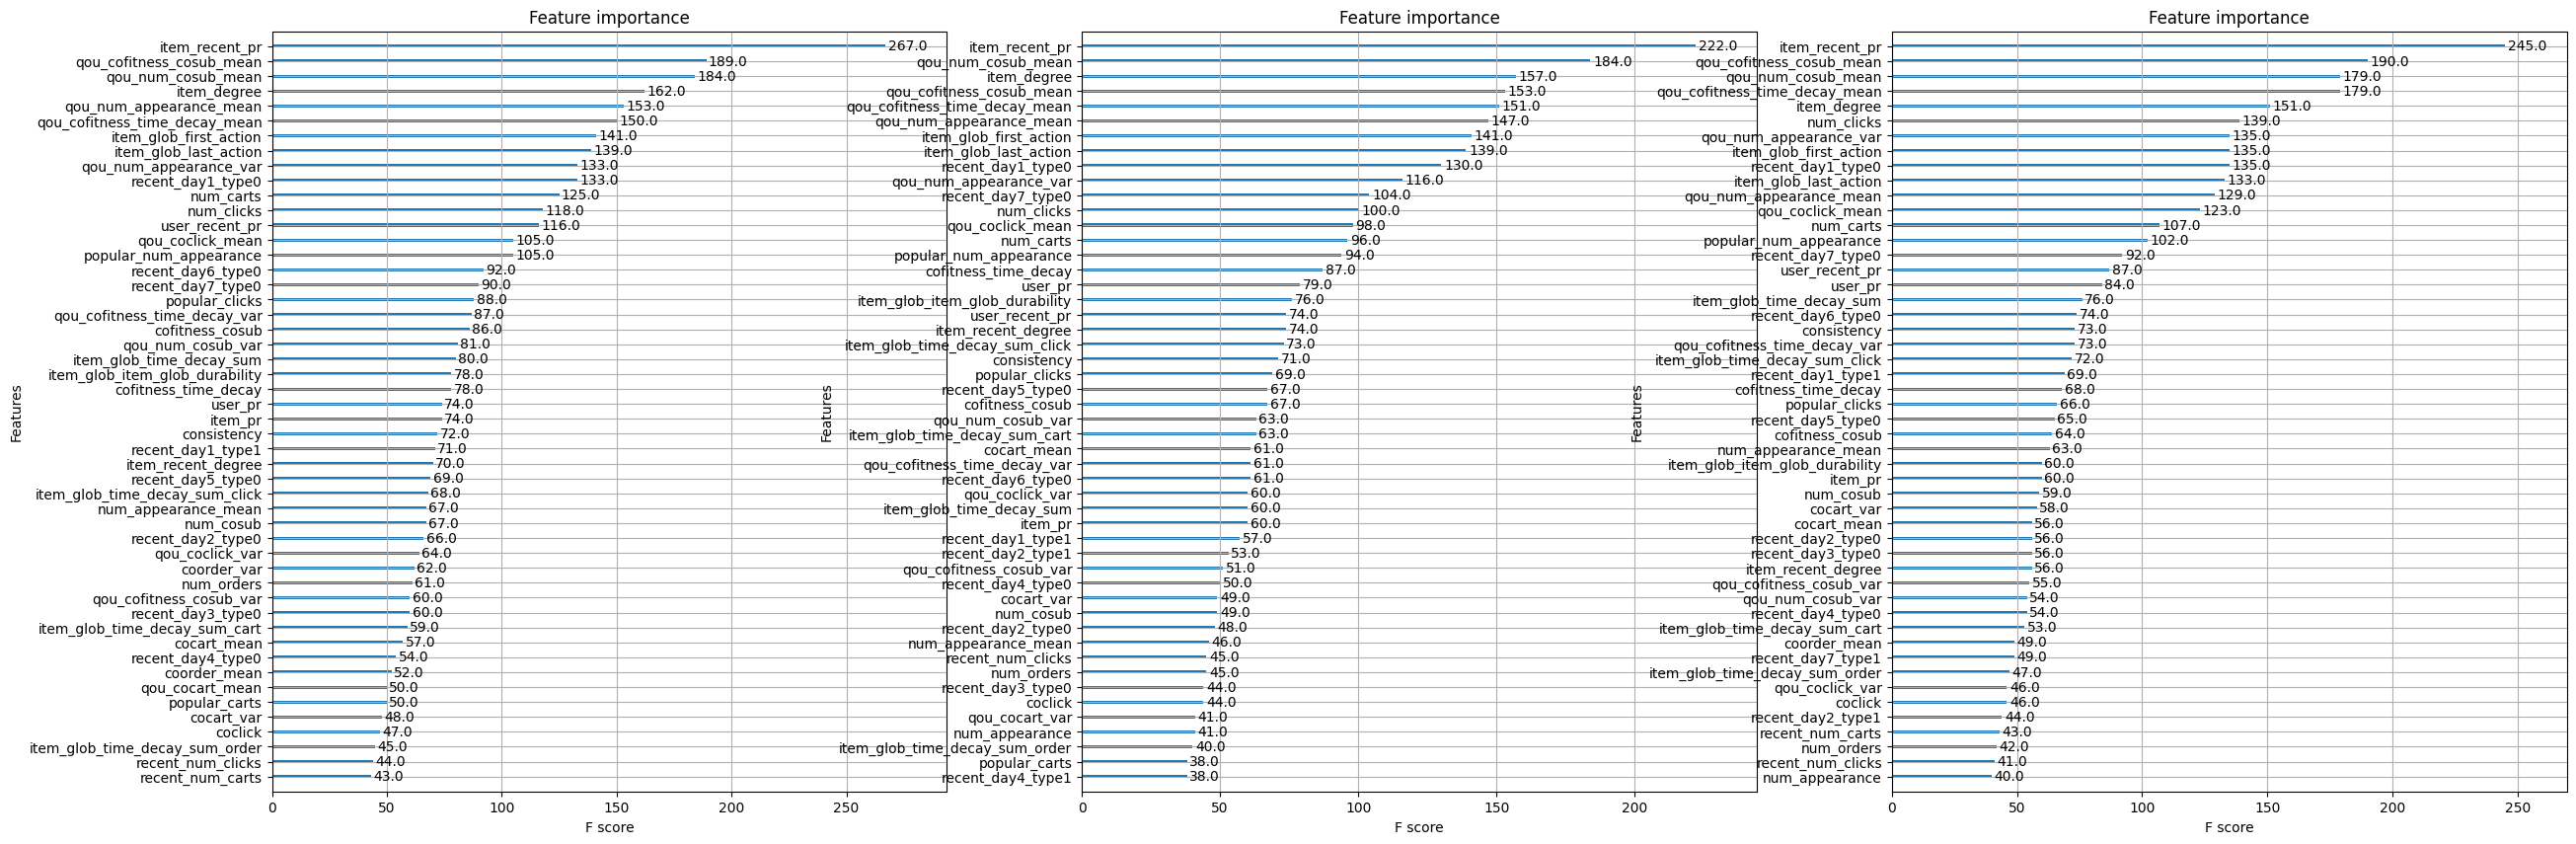

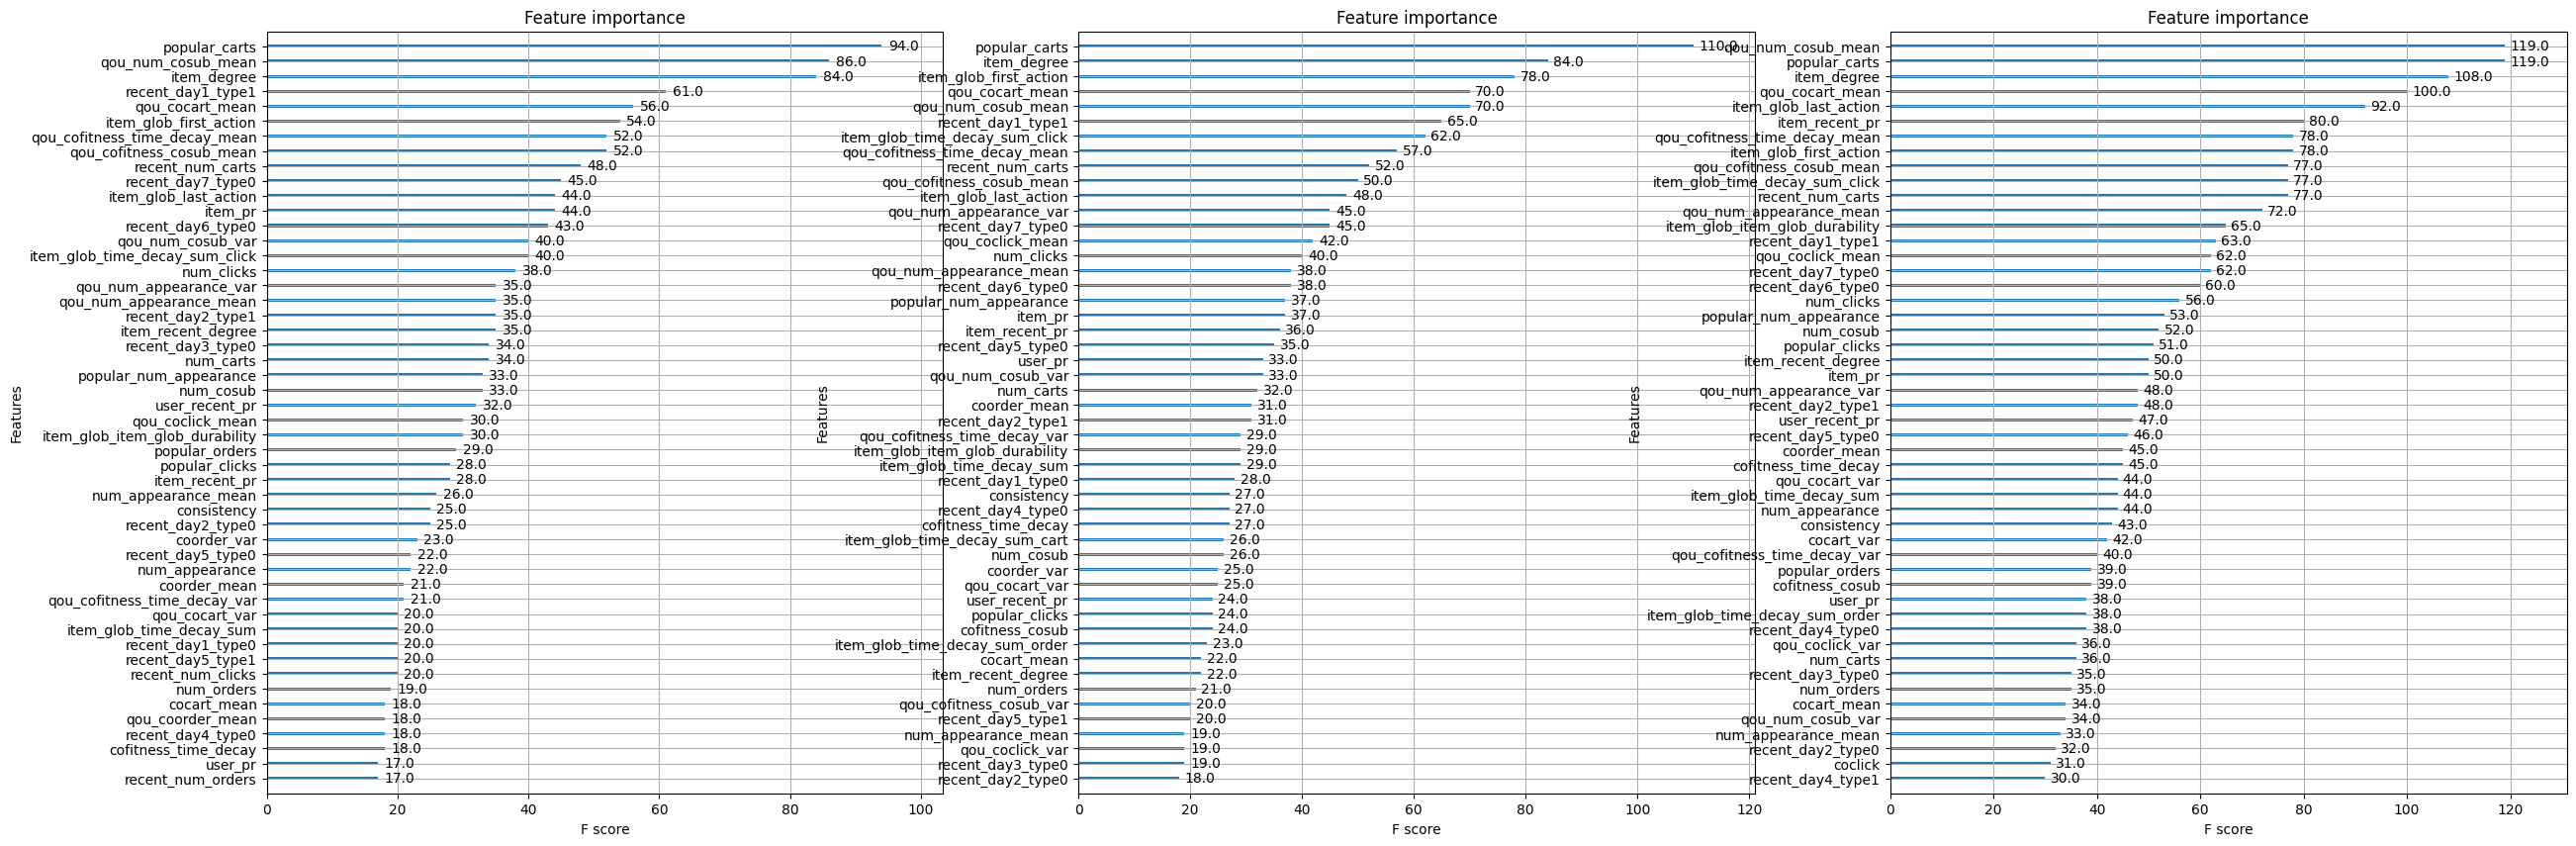

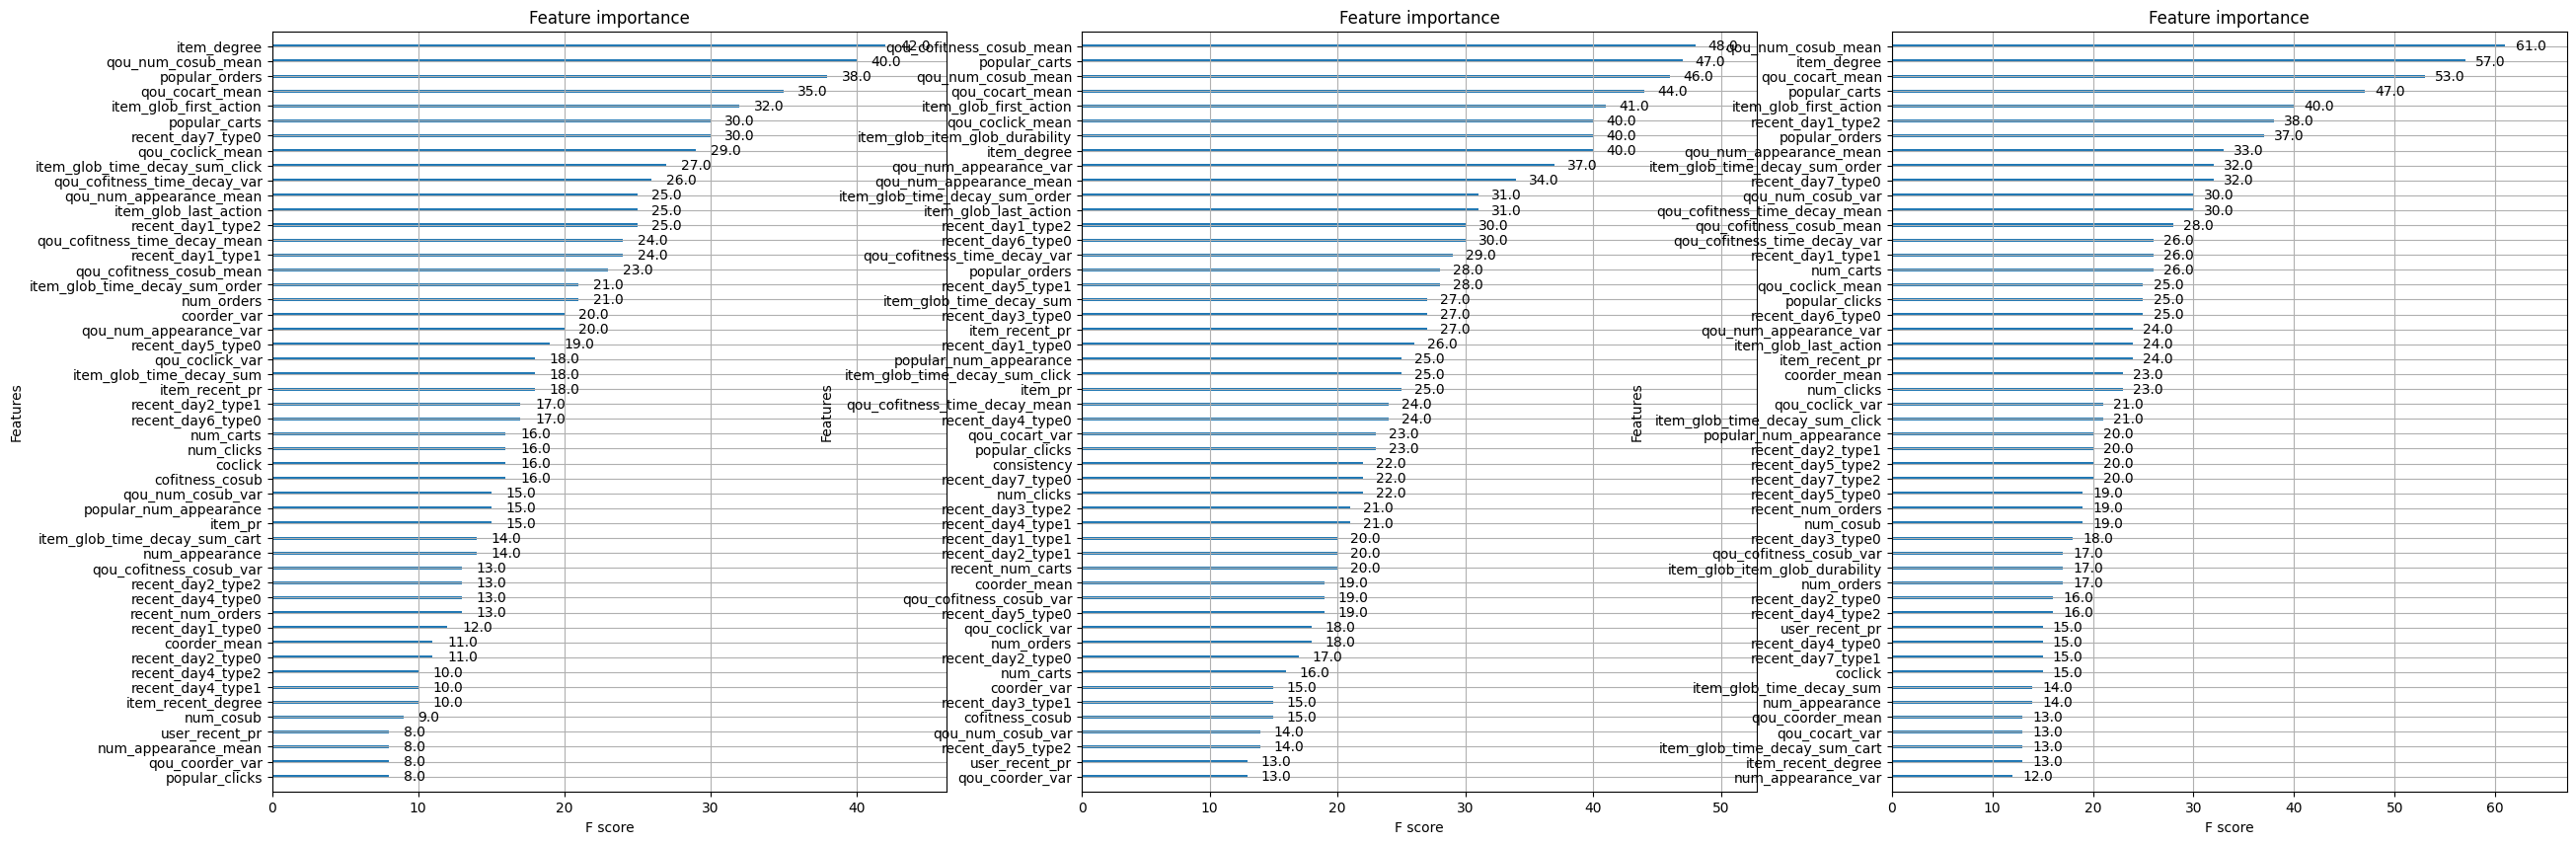

In [14]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(tar, candidates, num_cands, t, id_type)